In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

import IPython.display as ipd
import imageio
#import os
#model_dir = "/".join(os.getcwd().split("/")[:-1] + ['models/'])
model_dir = "./models/"
import models
from plot_utils import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from model_utils import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from helpers import trueAfterN, logsumexp
from sws_utils import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune
import copy
from tensorboardX import SummaryWriter
import pickle 

writeTensorboard = False
if(writeTensorboard):
    writer = SummaryWriter('tensorboard/run1/')

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")


#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_data_full = Variable(train_dataset.train_data.float()/255.0).cuda()
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
train_labels_full = Variable(train_dataset.train_labels).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()
use_cuda = torch.cuda.is_available()

#arguments
model_name = 'LeNet_300_100'
training_epochs=20
retraining_epochs=50
temp_list = [8]

In [3]:
#4D tensor fix for conv-net
test_data_full = test_data_full.view(10000, 1, 28, 28)
train_data_full = train_data_full.view(60000, 1, 28, 28)
model_name = 'SWSModel'

## LeNet 300-100

### 1. Train Model

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 250.0


**Epoch: 1**

Layer Loss: 147291.625
Layer Loss: 165.992
Layer Loss: 21380.977
Layer Loss: 63.684
Layer Loss: 998.946
Layer Loss: 5.666
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -1037279.125


**Epoch: 2**

**Epoch: 3**

**Epoch: 4**

**Epoch: 5**

**Epoch: 6**

**Epoch: 7**

**Epoch: 8**

**Epoch: 9**

**Epoch: 10**

Tau:5e-07
Epoch: 10. Training Accuracy: 99.70. Test Accuracy: 98.01
Means: [-0.62, -0.554, -0.481, -0.481, -0.259, -0.155, -0.068, -0.008, 0.064, 0.15, 0.24, 0.375, 0.474, 0.716, 0.606]
Mixing Proportions: [4.026, -3.425, -4.208, -4.239, -4.353, -4.256, -4.191, -4.175, -4.215, -4.311, -4.432, -4.487, -4.118, -3.163, 1.423]
Precisions: [5.29, 7.781, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794]


**Epoch: 11**

Layer Loss: -87283.812
Layer Loss: -26.136
Layer Loss: 13920.885
Layer Loss: 26.134
Layer Loss: 3139.626
Layer Loss: 0.080
0-neglogprop Loss: -26048.775
Remaining-neglogprop Loss: -2558721.000


**Epoch: 12**

**Epoch: 13**

**Epoch: 14**

**Epoch: 15**

**Epoch: 16**

**Epoch: 17**

**Epoch: 18**

**Epoch: 19**

**Epoch: 20**

Tau:5e-07
Epoch: 20. Training Accuracy: 99.71. Test Accuracy: 98.0
Means: [-0.626, -0.478, -0.316, -0.434, -0.297, -0.208, -0.068, -0.007, 0.064, 0.215, 0.215, 0.436, 0.323, 0.725, 0.604]
Mixing Proportions: [1.048, -6.75, 0.968, -1.727, -7.848, -7.739, -7.688, -7.672, -7.712, -7.63, -7.746, -2.864, 0.877, -5.644, -1.562]
Precisions: [6.936, 7.837, 7.824, 7.834, 7.824, 7.824, 7.824, 7.824, 7.824, 7.824, 7.824, 7.824, 7.824, 7.821, 7.824, 7.825]


**Epoch: 21**

Layer Loss: -273652.969
Layer Loss: 12.876
Layer Loss: -3408.826
Layer Loss: 15.334
Layer Loss: 6347.361
Layer Loss: 3.652
0-neglogprop Loss: -32615.232
Remaining-neglogprop Loss: -2558896.250


**Epoch: 22**

**Epoch: 23**

**Epoch: 24**

**Epoch: 25**

**Epoch: 26**

**Epoch: 27**

**Epoch: 28**

**Epoch: 29**

**Epoch: 30**

Tau:5e-07
Epoch: 30. Training Accuracy: 98.32. Test Accuracy: 97.35
Means: [-0.628, -0.48, -0.321, -0.467, -0.301, -0.118, -0.106, -0.01, 0.063, 0.127, 0.245, 0.454, 0.34, 0.712, 0.623]
Mixing Proportions: [-2.455, -10.785, -2.533, -5.294, -11.813, -1.744, -11.656, -11.641, -11.679, -0.931, -5.492, -6.642, -2.644, -9.224, -5.065]
Precisions: [10.798, 7.822, 7.824, 7.821, 7.823, 7.824, 7.801, 7.824, 7.824, 7.824, 7.748, 7.824, 7.824, 7.818, 7.824, 7.824]


**Epoch: 31**

Layer Loss: -740527.438
Layer Loss: -252.214
Layer Loss: -66401.016
Layer Loss: -3.243
Layer Loss: 7986.001
Layer Loss: 17.357
0-neglogprop Loss: 43878.059
Remaining-neglogprop Loss: -2558821.750


**Epoch: 32**

**Epoch: 33**

**Epoch: 34**

**Epoch: 35**

**Epoch: 36**

**Epoch: 37**

**Epoch: 38**

**Epoch: 39**

**Epoch: 40**

Tau:5e-07
Epoch: 40. Training Accuracy: 98.38. Test Accuracy: 97.37
Means: [-0.633, -0.479, -0.325, -0.505, -0.3, -0.131, -0.105, -0.011, 0.058, 0.144, 0.264, 0.484, 0.36, 0.703, 0.655]
Mixing Proportions: [-2.503, -12.291, -2.577, -5.367, -13.289, -1.791, -13.134, -13.119, -13.156, -0.986, -4.681, -6.183, -2.735, -12.158, -5.149]
Precisions: [11.063, 7.804, 7.824, 7.805, 7.823, 7.824, 7.783, 7.824, 7.824, 7.824, 7.72, 7.824, 7.824, 7.808, 7.824, 7.823]


**Epoch: 41**

Layer Loss: -792913.812
Layer Loss: -505.980
Layer Loss: -74124.148
Layer Loss: -129.055
Layer Loss: 7698.017
Layer Loss: 6.844
0-neglogprop Loss: 72179.516
Remaining-neglogprop Loss: -2558736.250


**Epoch: 42**

**Epoch: 43**

**Epoch: 44**

**Epoch: 45**

**Epoch: 46**

**Epoch: 47**

**Epoch: 48**

**Epoch: 49**

**Epoch: 50**

Tau:5e-07
Epoch: 50. Training Accuracy: 98.55. Test Accuracy: 97.48
Means: [-0.64, -0.478, -0.328, -0.513, -0.3, -0.139, -0.105, -0.016, 0.056, 0.152, 0.276, 0.494, 0.371, 0.703, 0.67]
Mixing Proportions: [-2.512, -13.497, -2.583, -5.33, -14.428, -1.801, -14.286, -14.272, -14.306, -0.998, -4.401, -5.888, -2.772, -13.532, -5.156]
Precisions: [11.079, 7.804, 7.824, 7.804, 7.823, 7.824, 7.779, 7.824, 7.824, 7.824, 7.711, 7.824, 7.824, 7.811, 7.824, 7.823]


**Epoch: 51**

Layer Loss: -796167.500
Layer Loss: -546.322
Layer Loss: -74535.672
Layer Loss: -124.551
Layer Loss: 7594.891
Layer Loss: 6.175
0-neglogprop Loss: 74252.453
Remaining-neglogprop Loss: -2558707.750


**Epoch: 52**

**Epoch: 53**

**Epoch: 54**

**Epoch: 55**

**Epoch: 56**

**Epoch: 57**

**Epoch: 58**

**Epoch: 59**

**Epoch: 60**

Tau:5e-07
Epoch: 60. Training Accuracy: 98.63. Test Accuracy: 97.57
Means: [-0.648, -0.477, -0.333, -0.515, -0.3, -0.147, -0.105, -0.016, 0.056, 0.157, 0.281, 0.513, 0.379, 0.703, 0.682]
Mixing Proportions: [-2.503, -14.55, -2.575, -5.331, -15.351, -1.792, -15.228, -15.217, -15.244, -0.994, -4.319, -5.85, -2.755, -14.614, -5.148]
Precisions: [11.085, 7.806, 7.824, 7.806, 7.823, 7.824, 7.778, 7.824, 7.824, 7.824, 7.713, 7.824, 7.824, 7.813, 7.824, 7.823]


**Epoch: 61**

Layer Loss: -797203.812
Layer Loss: -552.631
Layer Loss: -74869.664
Layer Loss: -121.604
Layer Loss: 7446.876
Layer Loss: 5.519
0-neglogprop Loss: 74941.586
Remaining-neglogprop Loss: -2558716.000


**Epoch: 62**

**Epoch: 63**

**Epoch: 64**

**Epoch: 65**

**Epoch: 66**

**Epoch: 67**

**Epoch: 68**

**Epoch: 69**

**Epoch: 70**

Tau:5e-07
Epoch: 70. Training Accuracy: 98.72. Test Accuracy: 97.56
Means: [-0.654, -0.477, -0.337, -0.512, -0.3, -0.153, -0.105, -0.016, 0.055, 0.162, 0.288, 0.535, 0.388, 0.703, 0.692]
Mixing Proportions: [-2.48, -15.422, -2.556, -5.499, -15.991, -1.777, -15.943, -15.935, -15.955, -0.98, -4.259, -5.874, -2.739, -15.48, -5.132]
Precisions: [11.088, 7.807, 7.824, 7.808, 7.823, 7.824, 7.78, 7.824, 7.824, 7.824, 7.717, 7.824, 7.824, 7.815, 7.824, 7.823]


**Epoch: 71**

Layer Loss: -797937.312
Layer Loss: -552.490
Layer Loss: -75124.430
Layer Loss: -118.060
Layer Loss: 7307.958
Layer Loss: 5.286
0-neglogprop Loss: 75364.812
Remaining-neglogprop Loss: -2558730.250


**Epoch: 72**

**Epoch: 73**

**Epoch: 74**

**Epoch: 75**

**Epoch: 76**

**Epoch: 77**

**Epoch: 78**

**Epoch: 79**

**Epoch: 80**

Tau:5e-07
Epoch: 80. Training Accuracy: 98.78. Test Accuracy: 97.58
Means: [-0.66, -0.477, -0.34, -0.509, -0.3, -0.159, -0.105, -0.016, 0.055, 0.165, 0.297, 0.556, 0.396, 0.703, 0.7]
Mixing Proportions: [-2.45, -16.075, -2.526, -5.487, -16.532, -1.749, -16.45, -16.444, -16.458, -0.951, -4.222, -5.878, -2.71, -16.118, -5.103]
Precisions: [11.09, 7.809, 7.824, 7.81, 7.823, 7.824, 7.781, 7.824, 7.824, 7.824, 7.722, 7.824, 7.824, 7.816, 7.824, 7.823]


**Epoch: 81**

Layer Loss: -798457.000
Layer Loss: -553.078
Layer Loss: -75299.305
Layer Loss: -116.073
Layer Loss: 7178.195
Layer Loss: 5.150
0-neglogprop Loss: 75620.859
Remaining-neglogprop Loss: -2558746.000


**Epoch: 82**

**Epoch: 83**

**Epoch: 84**

**Epoch: 85**

**Epoch: 86**

**Epoch: 87**

**Epoch: 88**

**Epoch: 89**

**Epoch: 90**

Tau:5e-07
Epoch: 90. Training Accuracy: 98.81. Test Accuracy: 97.48
Means: [-0.666, -0.477, -0.343, -0.504, -0.3, -0.164, -0.105, -0.016, 0.055, 0.168, 0.302, 0.574, 0.402, 0.703, 0.707]
Mixing Proportions: [-2.411, -16.532, -2.489, -5.456, -16.796, -1.712, -16.795, -16.795, -16.795, -0.913, -4.254, -5.85, -2.661, -16.563, -5.066]
Precisions: [11.093, 7.811, 7.824, 7.812, 7.823, 7.824, 7.783, 7.824, 7.824, 7.824, 7.726, 7.824, 7.824, 7.816, 7.824, 7.823]


**Epoch: 91**

Layer Loss: -799143.438
Layer Loss: -552.432
Layer Loss: -75452.992
Layer Loss: -115.945
Layer Loss: 7083.023
Layer Loss: 5.001
0-neglogprop Loss: 75946.750
Remaining-neglogprop Loss: -2558759.000


**Epoch: 92**

**Epoch: 93**

**Epoch: 94**

**Epoch: 95**

**Epoch: 96**

**Epoch: 97**

**Epoch: 98**

**Epoch: 99**

**Epoch: 100**

Tau:5e-07
Epoch: 100. Training Accuracy: 98.83. Test Accuracy: 97.46
Means: [-0.672, -0.477, -0.346, -0.501, -0.3, -0.169, -0.105, -0.016, 0.055, 0.171, 0.305, 0.59, 0.408, 0.703, 0.713]
Mixing Proportions: [-2.378, -16.857, -2.458, -5.416, -17.058, -1.68, -17.059, -17.059, -17.152, -0.88, -4.363, -5.819, -2.609, -16.881, -5.034]
Precisions: [11.093, 7.813, 7.824, 7.814, 7.823, 7.824, 7.784, 7.824, 7.824, 7.824, 7.73, 7.824, 7.824, 7.815, 7.824, 7.823]


**Epoch: 101**

Layer Loss: -799229.938
Layer Loss: -549.950
Layer Loss: -75583.773
Layer Loss: -118.881
Layer Loss: 6998.221
Layer Loss: 4.963
0-neglogprop Loss: 75952.398
Remaining-neglogprop Loss: -2558769.250


**Epoch: 102**

**Epoch: 103**

**Epoch: 104**

**Epoch: 105**

**Epoch: 106**

**Epoch: 107**

**Epoch: 108**

**Epoch: 109**

**Epoch: 110**

Tau:5e-07
Epoch: 110. Training Accuracy: 98.85. Test Accuracy: 97.51
Means: [-0.677, -0.477, -0.349, -0.504, -0.3, -0.173, -0.105, -0.016, 0.055, 0.174, 0.308, 0.605, 0.413, 0.703, 0.718]
Mixing Proportions: [-2.353, -17.103, -2.428, -5.446, -17.265, -1.656, -17.266, -17.266, -17.374, -0.853, -4.505, -5.795, -2.566, -17.122, -5.008]
Precisions: [11.093, 7.815, 7.824, 7.814, 7.823, 7.824, 7.786, 7.824, 7.824, 7.824, 7.733, 7.824, 7.824, 7.815, 7.824, 7.823]


**Epoch: 111**

Layer Loss: -799345.938
Layer Loss: -549.556
Layer Loss: -75676.258
Layer Loss: -124.243
Layer Loss: 6921.395
Layer Loss: 4.859
0-neglogprop Loss: 75957.945
Remaining-neglogprop Loss: -2558778.500


**Epoch: 112**

**Epoch: 113**

**Epoch: 114**

**Epoch: 115**

**Epoch: 116**

**Epoch: 117**

**Epoch: 118**

**Epoch: 119**

**Epoch: 120**

Tau:5e-07
Epoch: 120. Training Accuracy: 98.90. Test Accuracy: 97.59
Means: [-0.683, -0.477, -0.351, -0.507, -0.3, -0.177, -0.105, -0.016, 0.055, 0.176, 0.308, 0.618, 0.418, 0.703, 0.723]
Mixing Proportions: [-2.336, -17.298, -2.41, -5.452, -17.432, -1.639, -17.432, -17.432, -17.432, -0.836, -4.586, -5.795, -2.537, -17.314, -4.983]
Precisions: [11.094, 7.816, 7.824, 7.816, 7.823, 7.824, 7.787, 7.824, 7.824, 7.824, 7.737, 7.824, 7.824, 7.816, 7.824, 7.824]


**Epoch: 121**

Layer Loss: -799693.875
Layer Loss: -550.043
Layer Loss: -75778.727
Layer Loss: -127.407
Layer Loss: 6857.820
Layer Loss: 4.679
0-neglogprop Loss: 76057.930
Remaining-neglogprop Loss: -2558790.000


**Epoch: 122**

**Epoch: 123**

**Epoch: 124**

**Epoch: 125**

**Epoch: 126**

**Epoch: 127**

**Epoch: 128**

**Epoch: 129**

**Epoch: 130**

Tau:5e-07
Epoch: 130. Training Accuracy: 98.88. Test Accuracy: 97.44
Means: [-0.688, -0.477, -0.353, -0.508, -0.3, -0.181, -0.105, -0.016, 0.055, 0.178, 0.307, 0.627, 0.423, 0.703, 0.724]
Mixing Proportions: [-2.322, -17.46, -2.395, -5.439, -17.537, -1.625, -17.537, -17.537, -17.537, -0.821, -4.665, -5.88, -2.514, -17.474, -4.928]
Precisions: [11.094, 7.818, 7.824, 7.817, 7.823, 7.824, 7.789, 7.824, 7.824, 7.824, 7.74, 7.824, 7.824, 7.816, 7.824, 7.823]


**Epoch: 131**

Layer Loss: -799871.688
Layer Loss: -548.339
Layer Loss: -75873.750
Layer Loss: -129.280
Layer Loss: 6804.992
Layer Loss: 4.681
0-neglogprop Loss: 76122.625
Remaining-neglogprop Loss: -2558798.000


**Epoch: 132**

**Epoch: 133**

**Epoch: 134**

**Epoch: 135**

**Epoch: 136**

**Epoch: 137**

**Epoch: 138**

**Epoch: 139**

**Epoch: 140**

Tau:5e-07
Epoch: 140. Training Accuracy: 98.91. Test Accuracy: 97.48
Means: [-0.693, -0.477, -0.355, -0.511, -0.3, -0.185, -0.105, -0.016, 0.055, 0.18, 0.309, 0.633, 0.428, 0.703, 0.727]
Mixing Proportions: [-2.308, -17.599, -2.38, -5.451, -17.652, -1.61, -17.652, -17.652, -17.684, -0.807, -4.68, -5.961, -2.498, -17.61, -4.88]
Precisions: [11.095, 7.819, 7.824, 7.817, 7.823, 7.824, 7.79, 7.824, 7.824, 7.824, 7.743, 7.824, 7.824, 7.817, 7.824, 7.823]


**Epoch: 141**

Layer Loss: -800000.500
Layer Loss: -548.883
Layer Loss: -75945.805
Layer Loss: -131.727
Layer Loss: 6755.892
Layer Loss: 4.494
0-neglogprop Loss: 76165.117
Remaining-neglogprop Loss: -2558804.750


**Epoch: 142**

**Epoch: 143**

**Epoch: 144**

**Epoch: 145**

**Epoch: 146**

**Epoch: 147**

**Epoch: 148**

**Epoch: 149**

**Epoch: 150**

Tau:5e-07
Epoch: 150. Training Accuracy: 98.91. Test Accuracy: 97.48
Means: [-0.698, -0.477, -0.357, -0.513, -0.3, -0.188, -0.105, -0.016, 0.055, 0.181, 0.31, 0.639, 0.433, 0.703, 0.731]
Mixing Proportions: [-2.296, -17.719, -2.366, -5.442, -17.766, -1.599, -17.766, -17.766, -17.802, -0.794, -4.695, -6.001, -2.484, -17.729, -4.85]
Precisions: [11.094, 7.82, 7.824, 7.817, 7.823, 7.824, 7.791, 7.824, 7.824, 7.824, 7.746, 7.824, 7.824, 7.817, 7.824, 7.824]


**Epoch: 151**

Layer Loss: -799906.625
Layer Loss: -547.302
Layer Loss: -75987.391
Layer Loss: -132.954
Layer Loss: 6718.502
Layer Loss: 4.453
0-neglogprop Loss: 76046.477
Remaining-neglogprop Loss: -2558810.750


**Epoch: 152**

**Epoch: 153**

**Epoch: 154**

**Epoch: 155**

**Epoch: 156**

**Epoch: 157**

**Epoch: 158**

**Epoch: 159**

**Epoch: 160**

Tau:5e-07
Epoch: 160. Training Accuracy: 98.91. Test Accuracy: 97.52
Means: [-0.703, -0.477, -0.359, -0.516, -0.3, -0.191, -0.105, -0.016, 0.055, 0.183, 0.311, 0.646, 0.438, 0.703, 0.736]
Mixing Proportions: [-2.285, -17.825, -2.353, -5.457, -17.868, -1.589, -17.868, -17.868, -17.927, -0.784, -4.692, -5.995, -2.471, -17.835, -4.838]
Precisions: [11.095, 7.821, 7.824, 7.818, 7.823, 7.824, 7.792, 7.824, 7.824, 7.824, 7.749, 7.824, 7.824, 7.818, 7.824, 7.824]


**Epoch: 161**

Layer Loss: -800257.688
Layer Loss: -548.431
Layer Loss: -76061.016
Layer Loss: -135.226
Layer Loss: 6681.391
Layer Loss: 4.297
0-neglogprop Loss: 76241.359
Remaining-neglogprop Loss: -2558817.250


**Epoch: 162**

**Epoch: 163**

**Epoch: 164**

**Epoch: 165**

**Epoch: 166**

**Epoch: 167**

**Epoch: 168**

**Epoch: 169**

**Epoch: 170**

Tau:5e-07
Epoch: 170. Training Accuracy: 98.93. Test Accuracy: 97.44
Means: [-0.707, -0.477, -0.361, -0.518, -0.3, -0.193, -0.105, -0.016, 0.055, 0.184, 0.313, 0.651, 0.443, 0.703, 0.741]
Mixing Proportions: [-2.276, -17.92, -2.344, -5.448, -17.959, -1.58, -17.96, -17.959, -18.031, -0.776, -4.677, -5.997, -2.461, -17.929, -4.826]
Precisions: [11.095, 7.821, 7.824, 7.818, 7.823, 7.824, 7.792, 7.824, 7.824, 7.824, 7.751, 7.824, 7.824, 7.818, 7.824, 7.824]


**Epoch: 171**

Layer Loss: -800314.312
Layer Loss: -547.172
Layer Loss: -76095.180
Layer Loss: -135.762
Layer Loss: 6650.229
Layer Loss: 4.244
0-neglogprop Loss: 76267.938
Remaining-neglogprop Loss: -2558821.500


**Epoch: 172**

**Epoch: 173**

**Epoch: 174**

**Epoch: 175**

**Epoch: 176**

**Epoch: 177**

**Epoch: 178**

**Epoch: 179**

**Epoch: 180**

Tau:5e-07
Epoch: 180. Training Accuracy: 98.96. Test Accuracy: 97.41
Means: [-0.712, -0.477, -0.362, -0.519, -0.3, -0.196, -0.105, -0.016, 0.055, 0.186, 0.315, 0.655, 0.447, 0.703, 0.745]
Mixing Proportions: [-2.267, -18.007, -2.334, -5.439, -18.043, -1.571, -18.043, -18.043, -18.12, -0.766, -4.685, -6.062, -2.45, -18.015, -4.794]
Precisions: [11.095, 7.822, 7.824, 7.819, 7.823, 7.824, 7.793, 7.824, 7.824, 7.824, 7.753, 7.824, 7.824, 7.818, 7.824, 7.824]


**Epoch: 181**

Layer Loss: -800189.625
Layer Loss: -549.401
Layer Loss: -76100.805
Layer Loss: -137.587
Layer Loss: 6630.433
Layer Loss: 4.134
0-neglogprop Loss: 76179.625
Remaining-neglogprop Loss: -2558825.000


**Epoch: 182**

**Epoch: 183**

**Epoch: 184**

**Epoch: 185**

**Epoch: 186**

**Epoch: 187**

**Epoch: 188**

**Epoch: 189**

**Epoch: 190**

Tau:5e-07
Epoch: 190. Training Accuracy: 98.89. Test Accuracy: 97.35
Means: [-0.716, -0.477, -0.364, -0.521, -0.301, -0.198, -0.105, -0.016, 0.055, 0.187, 0.317, 0.65, 0.451, 0.703, 0.747]
Mixing Proportions: [-2.256, -18.086, -2.322, -5.428, -18.119, -1.56, -18.119, -18.119, -18.191, -0.755, -4.669, -6.268, -2.439, -18.093, -4.73]
Precisions: [11.095, 7.822, 7.824, 7.818, 7.823, 7.824, 7.793, 7.824, 7.824, 7.824, 7.754, 7.824, 7.824, 7.818, 7.824, 7.823]


**Epoch: 191**

Layer Loss: -800222.562
Layer Loss: -548.854
Layer Loss: -76110.250
Layer Loss: -138.162
Layer Loss: 6616.819
Layer Loss: 4.196
0-neglogprop Loss: 76170.797
Remaining-neglogprop Loss: -2558827.500


**Epoch: 192**

**Epoch: 193**

**Epoch: 194**

**Epoch: 195**

**Epoch: 196**

**Epoch: 197**

**Epoch: 198**

**Epoch: 199**

**Epoch: 200**

Tau:5e-07
Epoch: 200. Training Accuracy: 98.95. Test Accuracy: 97.35
Means: [-0.72, -0.477, -0.365, -0.523, -0.301, -0.201, -0.105, -0.016, 0.055, 0.188, 0.319, 0.65, 0.455, 0.703, 0.752]
Mixing Proportions: [-2.249, -18.158, -2.317, -5.421, -18.189, -1.553, -18.189, -18.189, -18.195, -0.748, -4.698, -6.298, -2.43, -18.165, -4.716]
Precisions: [11.096, 7.823, 7.824, 7.819, 7.823, 7.824, 7.793, 7.824, 7.824, 7.824, 7.755, 7.824, 7.824, 7.818, 7.824, 7.824]


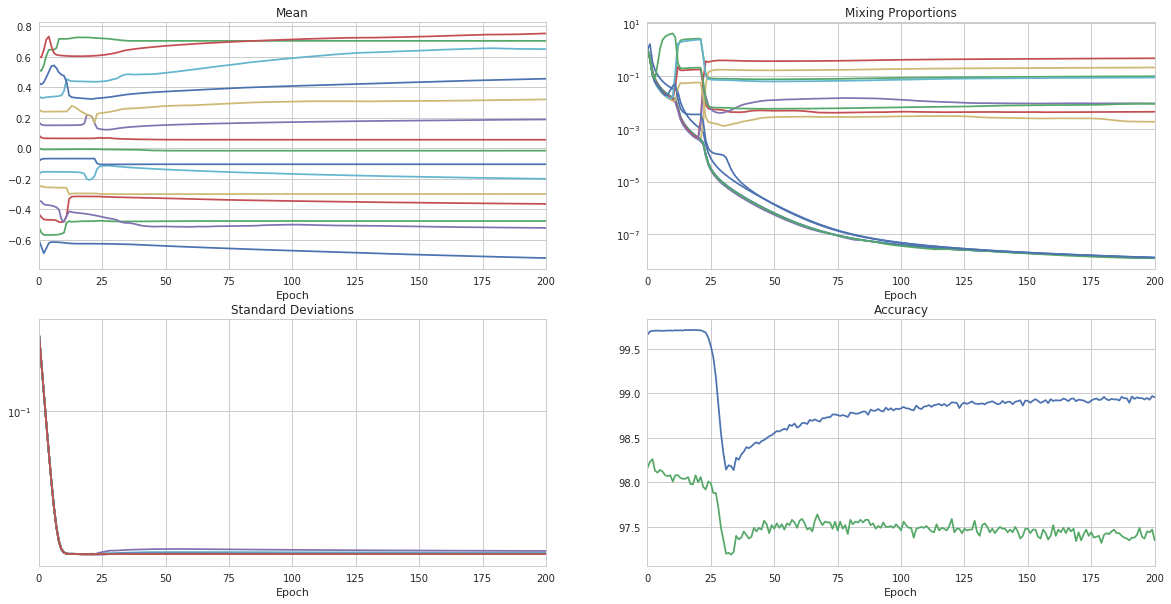

<IPython.core.display.Javascript object>

In [113]:
%%notify
#model = models.LeNet_300_100().cuda()
#print_dims(model)
alpha, beta = (25000, 10)
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, 100)).cuda()
gmp = GaussianMixturePrior(16, [x for x in model.parameters()], 0.99, ab = (alpha, beta))

test_acc = test_accuracy(test_data_full, test_labels_full, model)
train_acc = test_accuracy(train_data_full, train_labels_full, model)
acc_history = np.array([train_acc[0], test_acc[0]])
stddev_history = np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy())
mean_history = gmp.means.data.clone().cpu().numpy()
mixprop_history = gmp.rhos.exp().data.clone().cpu().numpy()

sws_param1 = [gmp.means]
sws_param2 = [gmp.gammas, gmp.rhos]
#ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_gmp = torch.optim.Adam(sws_param1, lr=1e-4)
optimizer_gmp2 = torch.optim.Adam(sws_param2, lr=3e-3)
graph_title='original_model/'

retraining_epochs = 200
decay = np.linspace(5e-7, 5e-6, retraining_epochs)
#decay = 5e-7 * np.power(10, decay)
#decay = 5e-5 * (1 - 1 / np.power(10, decay))

exp_name = "a{}_b{}_r{}".format(alpha, beta, retraining_epochs)

for epoch in range(retraining_epochs):
    ipd.display(ipd.Markdown("**Epoch: {}**".format(epoch+1)))
    #tau = float(decay[epoch])
    tau=5e-7
    model, loss = retrain_sws_epoch(model, gmp, optimizer, optimizer_gmp, optimizer_gmp2, criterion, train_loader, tau)

    test_acc = test_accuracy(test_data_full, test_labels_full, model)
    train_acc = test_accuracy(train_data_full, train_labels_full, model)
    weight_penalty = get_weight_penalty(model)

    stddev_history = np.vstack((stddev_history,  np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy()) ))
    mean_history = np.vstack((mean_history, gmp.means.data.clone().cpu().numpy() ))
    mixprop_history = np.vstack((mixprop_history, gmp.rhos.exp().data.clone().cpu().numpy() ))
    acc_history = np.vstack(( acc_history, np.array([train_acc[0], test_acc[0]]) ))

    if(writeTensorboard):
        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    if (trueAfterN(epoch, 10)):
        gmp.print_batch = True
        print ('Tau:{}'.format(tau))
        print('Epoch: {}. Training Accuracy: {:.2f}. Test Accuracy: {}'.format(epoch+1, train_acc[0], test_acc[0]))
        print ( "Means: {}".format(list(np.around(gmp.means.data.clone().cpu().numpy(),3))) )
        print ( "Mixing Proportions: {}".format(list(np.around(gmp.rhos.data.clone().cpu().numpy(),3))) )
        print ( "Precisions: {}".format(list(np.around(gmp.gammas.data.clone().cpu().numpy(),3))) )
    show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch, accuracy = test_acc[0], savefile = exp_name)
        #show_all_weights(model)

draw_sws_graphs(mean_history, stddev_history, mixprop_history, acc_history, exp_name)
images = []
filenames = ["figs/{}_{}.png".format(exp_name, x) for x in range(1,retraining_epochs+1)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./exp/{}.gif'.format(exp_name), images)
torch.save(model, model_dir + 'mnist_retrain_m{}_a{}_b{}_r{}.m'.format(model.name, retraining_epochs, alpha, beta))
with open(model_dir + 'mnist_retrain_m{}_a{}_b{}_r{}_gmp.p'.format(model.name, retraining_epochs, alpha, beta),'wb') as f:
    pickle.dump(gmp, f)
#torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, training_epochs))
ipd.HTML('<img src="./exp/{}.gif">'.format(exp_name))

In [ ]:
with open(fn, 'rb') as f:
    gmp2 = pickle.load(f)

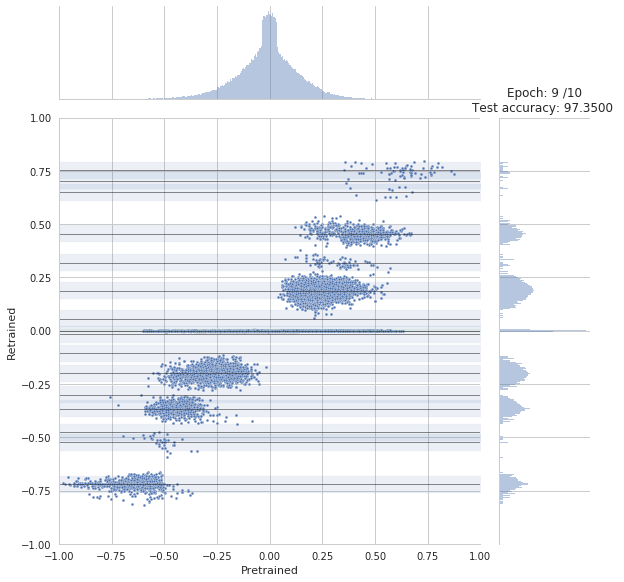

In [157]:
## jointplot
model_orig = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, 100)).cuda()
    
jointplot(model, model_orig, gmp, 8, 10, 90)

### Post-Processing

In [179]:
pruned_model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, 100)).cuda()
pruned_model.load_state_dict(sws_prune(model, gmp))
test_accuracy(test_data_full, test_labels_full, pruned_model)
print ("Pruned %: {}".format((special_flatten(pruned_model.state_dict())==0).sum()/266610 * 100))

Pruned %: 97.11263643524249


### 2. Re-train Model

In [4]:
retraining_epochs=40

In [11]:
model_kd.name

'SWSModel'

**Temperature = 8**

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'models.SWSModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


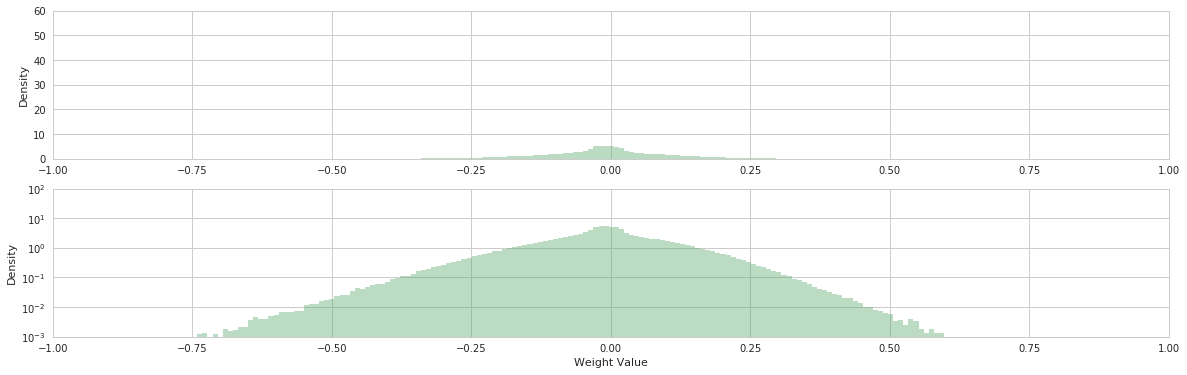

Epoch: 20. Train CE Loss: 1.570, Train Accuracy: 95.897, Test CE Loss: 1.566, Test Accuracy: 96.170, Model L2: 10.133
Epoch: 40. Train CE Loss: 1.567, Train Accuracy: 96.177, Test CE Loss: 1.563, Test Accuracy: 96.280, Model L2: 9.712


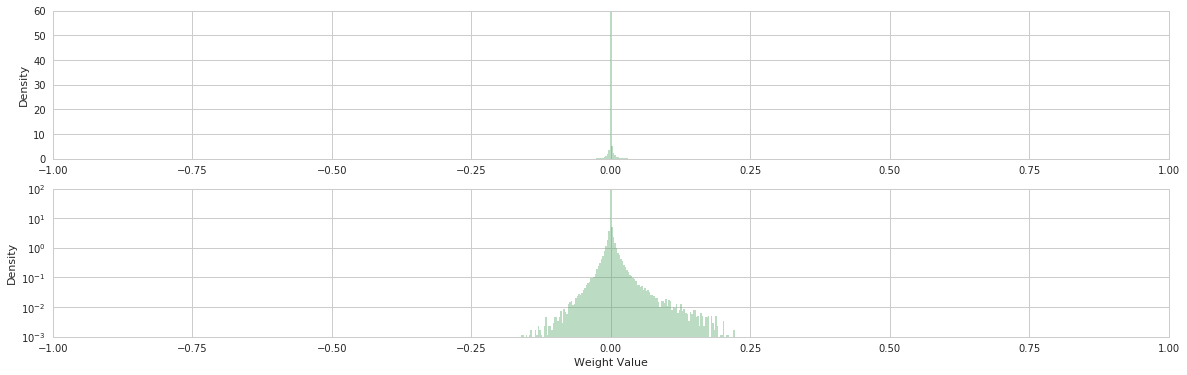

In [6]:
#Get KD Targets   
for temp in temp_list:
    ipd.display(ipd.Markdown("**Temperature = {}**".format(temp)))
    model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, 100)).cuda()
    kd_outputs = model.kd_targets(train_data_full,T=temp)
    kd_dataset = torch.utils.data.TensorDataset(train_data_full.data, kd_outputs.data)#.data turns variable -> tensor
    train_kd_loader = torch.utils.data.DataLoader(dataset=kd_dataset, batch_size=batch_size, shuffle=True)

    #Load model
    model_kd = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, 100)).cuda()
    show_sws_weights(model_kd)

    #Set up Optimisers and loss
    criterion_kd = nn.MSELoss()
    learning_rate_kd = 0.0005
    wd_kd = 0.001
    optimizer_kd_1 = torch.optim.Adam(model_kd.conv1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_2 = torch.optim.Adam(model_kd.conv2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_3 = torch.optim.Adam(model_kd.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_4 = torch.optim.Adam(model_kd.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

    graph_title = "compressed_model_T_{}/".format(temp)

    for epoch in range(retraining_epochs):
        model_kd, loss = train_epoch(model_kd, optimizer_kd_4, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_3, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_2, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_1, criterion_kd, train_kd_loader)
        test_acc = test_accuracy(test_data_full, test_labels_full, model_kd)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_kd)
        weight_penalty = get_weight_penalty(model_kd)

        #writer.add_scalars(graph_title + 'train_CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        #writer.add_scalars(graph_title + 'train_Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        #writer.add_scalars(graph_title + 'train_L2', {'L2' : weight_penalty}, epoch+1)
        #for name, param in model.named_parameters():
        #    writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
        if (epoch%20==19):
            print('Epoch: {}. Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}'.format(epoch+1, train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty))
    torch.save(model_kd, model_dir + 'mnist_{}_kd_t{}_e{}.m'.format(model_kd.name, temp, retraining_epochs))
    show_sws_weights(model_kd)

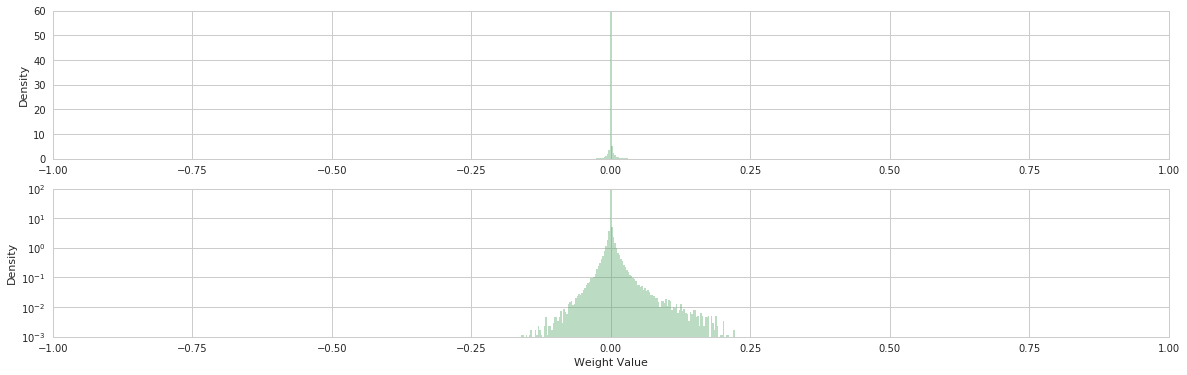

In [7]:
show_sws_weights(model_kd)

### 3. Prune Model

**Temperature = 8**

Train CE Loss: 1.683, Train Accuracy: 91.180, Test CE Loss: 1.676, Test Accuracy: 91.300, Model L2: 9.395, Parameters Pruned: 618745/642460 - 96.309%
Train CE Loss: 1.907, Train Accuracy: 93.683, Test CE Loss: 1.899, Test Accuracy: 94.050, Model L2: 8.832, Parameters Pruned: 545593/642460 - 84.922%


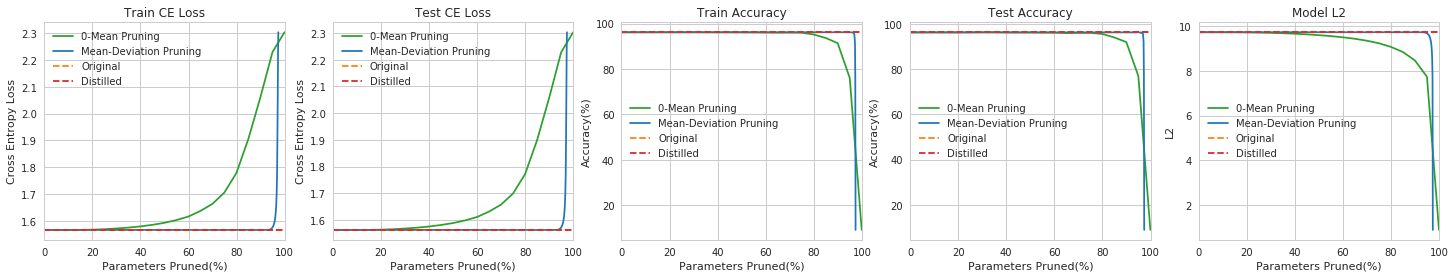

In [14]:
#Original Model
model = torch.load(model_dir + 'mnist_{}_kd_t{}_e{}.m'.format(model_kd.name, temp, retraining_epochs)).cuda()
test_acc_o = test_accuracy(test_data_full, test_labels_full, model)
train_acc_o = test_accuracy(train_data_full, train_labels_full, model)
weight_penalty_o = get_weight_penalty(model)
compress_res = {}

for temp in temp_list:
    ipd.display(ipd.Markdown("**Temperature = {}**".format(temp)))
    graph_title = "compressed_model_T_{}/".format(temp)
    #Retrained Model
    model_kd = torch.load(model_dir + 'mnist_{}_kd_t{}_e{}.m'.format(model_kd.name, temp, retraining_epochs)).cuda()
    test_acc_kd = test_accuracy(test_data_full, test_labels_full, model_kd)
    train_acc_kd = test_accuracy(train_data_full, train_labels_full, model_kd)
    weight_penalty_kd = get_weight_penalty(model_kd)
    
    #writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 0)
    #writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 100)
    #writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 0)
    #writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 100)
    #writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 0)
    #writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 100)
    
    model_c = models.SWSModel().cuda()
    pruner = model_prune(model_kd.state_dict())
    deviation_list = [x/10.0 for x in range(0,21)]
    percentile_list = range(0,101,5)
    
    
    dev_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []}
    for i,lim in enumerate(deviation_list):
        model_c.load_state_dict(pruner.deviation_prune(lim))
        test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
        weight_penalty = get_weight_penalty(model_c)

        dev_res['train ce'].append(train_acc[1])
        dev_res['test ce'].append(test_acc[1])
        dev_res['train acc'].append(train_acc[0])
        dev_res['test acc'].append(test_acc[0])
        dev_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
        dev_res['L2'].append(weight_penalty)

        #writer.add_scalars(graph_title + 'prune_CrossEntropyLoss', {'Deviation Test': test_acc[1], 'Deviation Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        #writer.add_scalars(graph_title + 'prune_Accuracy', {'Deviation Test': test_acc[0], 'Deviation Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        #writer.add_scalars(graph_title + 'prune_L2', {'Deviation': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)

        if(i==13):
            print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
              .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))
    
    perc_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : [],} 
    for i,lim in enumerate(percentile_list):
        model_c.load_state_dict(pruner.percentile_prune(lim))

        test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
        weight_penalty = get_weight_penalty(model_c)
        perc_res['train ce'].append(train_acc[1])
        perc_res['test ce'].append(test_acc[1])
        perc_res['train acc'].append(train_acc[0])
        perc_res['test acc'].append(test_acc[0])
        perc_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
        perc_res['L2'].append(weight_penalty)

        #writer.add_scalars(graph_title + 'prune_CrossEntropyLoss', {'Percentile Test': test_acc[1], 'Percentile Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        #writer.add_scalars(graph_title + 'prune_Accuracy', {'Percentile Test': test_acc[0], 'Percentile Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        #writer.add_scalars(graph_title + 'prune_L2', {'Percentile': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)
        
        if(i==17):
            print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
              .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))
            
    prune_plot(temp, dev_res, perc_res, test_acc_o, train_acc_o, weight_penalty_o, test_acc_kd, train_acc_kd, weight_penalty_kd)
    #t_res={} 
    #t_res['dev']=dev_res
    #t_res['perc']=perc_res
    #compress_res[temp]=t_res